##  **0. 라이브러리 불러오기**

In [1]:

import pandas as pd
import numpy as np

#from sklearn.model_selection import train_test_split
#from sklearn.linear_model import LogisticRegression
#import statsmodels.api as sm
#from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import StandardScaler
#from sklearn.metrics import classification_report

# 데이터 분포 확인을 위한 plt 라이브러리 import 
import matplotlib.pyplot as plt
import seaborn as sns

## **1. 분석 데이터 만들기**

In [ ]:
## 데이터 불러오기

orders = pd.read_csv("olist_orders_dataset.csv")
order_items = pd.read_csv("olist_order_items_dataset.csv")
sellers = pd.read_csv("olist_sellers_dataset.csv")
reviews = pd.read_csv("olist_order_reviews_dataset.csv")
#payments = pd.read_csv("olist_order_payments_dataset.csv")
#customers = pd.read_csv("olist_customers_dataset.csv")

reviews_wj = pd.read_csv("reviews_wj_fin.csv", encoding='latin1', on_bad_lines='skip')

In [2]:
## 데이터 전처리 통합 마스터 테이블 불러오기
prep = pd.read_csv("merged_olist.csv")

#### **1-1. reviews_wj 데이터셋 정제하기**

In [3]:
# 양옆 공백을 제거한 버전의 길이를 계산
temp_len = reviews_wj['order_id'].astype(str).str.strip().str.len()

# 32자리가 아닌 것들 다시 필터링
wrong_orders = reviews_wj[temp_len != 32]

print(f"공백 제거 후 발견된 이상 데이터: {len(wrong_orders)}건")

공백 제거 후 발견된 이상 데이터: 123건


In [4]:
# 쏙 뽑아서 제거하기
# 이상 데이터의 인덱스번호만 따로 추출
bad_indices = reviews_wj[reviews_wj['order_id'].astype(str).str.strip().str.len() != 32].index

# 해당 인덱스 삭제
reviews_wj = reviews_wj.drop(bad_indices)

# 인덱스 초기화
reviews_wj = reviews_wj.reset_index(drop=True)

# 길이 분포 확인 (32만 남아있어야 정상)
print("현재 데이터의 ID 길이 분포:")
print(reviews_wj['order_id'].astype(str).str.strip().str.len().value_counts())

현재 데이터의 ID 길이 분포:
order_id
32    99074
Name: count, dtype: int64


#### **1-2. merge 하기**

In [5]:
## 주문T + 리뷰T
# 주문(99441행) + 리뷰 => df1(99992행)
# 리뷰 데이터에 order_id별로 여러개의 리뷰 있음 (2개 이상있는 행: 547)

df1 = orders.merge(
    reviews_wj,
    on="order_id",
    how="left"
)

In [6]:
## 행 갯수 확인
print("주문T 행 갯수 :", len(orders))
print("리뷰 2개 이상있는 order_id 수 :", len(reviews_wj['order_id'].value_counts()[lambda x: x >= 2]))

주문T 행 갯수 : 99441
리뷰 2개 이상있는 order_id 수 : 547


In [7]:
## 주문+리뷰T + 상품T (items)
df1 = df1.merge(
        order_items[["order_id", "seller_id", "product_id", "shipping_limit_date"]],
        on="order_id",
        how="left"
)

In [8]:
## 주문+리뷰+상품T + 판매자T
df1 = df1.merge(
        sellers[["seller_id", "seller_state"]],
        on="seller_id",
        how="left"
)

In [9]:
df1

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_comment_message,review_score,seller_id,product_id,shipping_limit_date,seller_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,"Nao testei o produto ainda, mas ele veio corre...",5.0,3504c0cb71d7fa48d967e0e4c94d59d9,87285b34884572647811a353c7ac498a,2017-10-06 11:07:15,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,Muito bom o produto.,5.0,289cdb325fb7e7f891c38608bf9e0962,595fac2a385ac33a80bd5114aec74eb8,2018-07-30 03:24:27,SP
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,NaN,1.0,4869f7a5dfa277a7dca6462dcf3b52b2,aa4383b373c6aca5d8797843e5594415,2018-08-13 08:55:23,SP
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,O produto foi exatamente o que eu esperava e e...,5.0,66922902710d126a0e7d26b0e3805106,d0b61bfb1de832b15ba9d266ca96e5b0,2017-11-23 19:45:59,MG
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,NaN,5.0,2c9e548be18521d1c43cde1c582c6de8,65266b2da20d04dbe00c5c2d3bb7859e,2018-02-19 20:31:37,SP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114087,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00,So uma peca que veio rachado mas tudo bem rs,2.0,1f9ab4708f3056ede07124aad39a2554,f1d4ce8c6dd66c47bbaa8c6781c2a923,2018-02-12 13:10:37,SP
114088,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00,Foi entregue antes do prazo.,5.0,d50d79cb34e38265a8649c383dcffd48,b80910977a37536adeddd63663f916ad,2017-09-05 15:04:16,SP
114089,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00,Foi entregue somente 1. Quero saber do outro p...,3.0,a1043bafd471dff536d0c462352beb48,d1c427060a0f73f6b889a5c7c61f2ac4,2018-01-12 21:36:21,MG
114090,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00,Foi entregue somente 1. Quero saber do outro p...,3.0,a1043bafd471dff536d0c462352beb48,d1c427060a0f73f6b889a5c7c61f2ac4,2018-01-12 21:36:21,MG


#### **1-3. 날짜변수 날짜 형식으로 바꾸기**

In [10]:
## 날짜형 변수 변환
date_cols = [
    'order_purchase_timestamp', 
    'order_approved_at', 
    'order_delivered_carrier_date', 
    'order_delivered_customer_date', 
    'order_estimated_delivery_date',
    'shipping_limit_date'
]

for col in date_cols:
    df1[col] = pd.to_datetime(df1[col])

#### **1-4. 배송 관련 파생변수 만들기**

In [11]:
## 배송 관련 파생 변수

# 배송 지연 기간 (일, float)
df1["delivery_delay_days"] = (
    df1["order_delivered_customer_date"]
    - df1["order_estimated_delivery_date"]
).dt.total_seconds() / (60 * 60 * 24)

# 출고까지 걸린 기간 (일, float)
df1["processing_days"] = (
    df1["order_delivered_carrier_date"]
    - df1["order_approved_at"]
).dt.total_seconds() / (60 * 60 * 24)

# 운송 기간 (일, float)
df1["shipping_days"] = (
    df1["order_delivered_customer_date"]
    - df1["order_delivered_carrier_date"]
).dt.total_seconds() / (60 * 60 * 24)


##
## **2. EDA (결측치, 이상치)**

#### **2-1. 2017-01 ~ 2018-09 데이터 필터링**

In [12]:
## 2017년 1월 ~ 2018년 9월 데이터 필터링
df2 = df1.copy()

df2 = df2.query("order_purchase_timestamp >= '2017-01-01' and order_purchase_timestamp <= '2018-09-30'")

# 결과 출력
print("필터링 전 주문 건수 :", len(df1))
print("필터링 후 주문 건수 :", len(df2))
print("제외된 주문 건수 :", len(df1)-len(df2))
print(f"데이터 기간: {df2['order_purchase_timestamp'].min()} ~ {df2['order_purchase_timestamp'].max()}")

필터링 전 주문 건수 : 114092
필터링 후 주문 건수 : 113697
제외된 주문 건수 : 395
데이터 기간: 2017-01-05 11:56:06 ~ 2018-09-29 09:13:03


#### **2-2. 배송 흐름 안 맞는 데이터 삭제**

In [13]:
## 출고-배달 흐름 이상
# NaN 행도 삭제됨

df22 = df2[
    (df2["processing_days"] >= 0) &
    (df2["shipping_days"] >= 0)
]

# 결과 출력
print("필터링 전 주문 건수 :", len(df2))
print("필터링 후 주문 건수 :", len(df22))
print("제외된 주문 건수 :", len(df2)-len(df22))

필터링 전 주문 건수 : 113697
필터링 후 주문 건수 : 108907
제외된 주문 건수 : 4790


In [14]:
## 배송흐름 정리 후 데이터 확인

print("\n[배송흐름 정리 후 주문 상태]")
print(df22["order_status"].value_counts())

print("\n[df22 결측치 확인]")
print(df22.isna().sum())


[배송흐름 정리 후 주문 상태]
order_status
delivered    108906
canceled          1
Name: count, dtype: int64

[df22 결측치 확인]
order_id                             0
customer_id                          0
order_status                         0
order_purchase_timestamp             0
order_approved_at                    0
order_delivered_carrier_date         0
order_delivered_customer_date        0
order_estimated_delivery_date        0
review_comment_message           61982
review_score                       992
seller_id                            0
product_id                           0
shipping_limit_date                  0
seller_state                         0
delivery_delay_days                  0
processing_days                      0
shipping_days                        0
dtype: int64


#### **2-3. 리뷰 정보 (text, score) 없는 행 삭제**

In [15]:
# 리뷰 기반 유의 판매자 판별 주제에 맞추려면 필요하지 않을가....? ㅁㄹ

## 리뷰 정보 없는 행 삭제
df23 = df22.dropna(
    subset=["review_comment_message", "review_score"]
)

print("\n[df23 결측치 확인]")
print(df23.isna().sum())


[df23 결측치 확인]
order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
review_comment_message           0
review_score                     0
seller_id                        0
product_id                       0
shipping_limit_date              0
seller_state                     0
delivery_delay_days              0
processing_days                  0
shipping_days                    0
dtype: int64


**[추가로 고려해야될 부분]**  
  - products (사진 개수, 상품 설명 길이, 상품 제목 유무)
  - total_orders 기준 (유석: -10/11-21/22-)
  - 또 나온게 뭐 있지?????

##
## **3. EDA (시각화)**

#### **3-1. 기본 분포 확인**

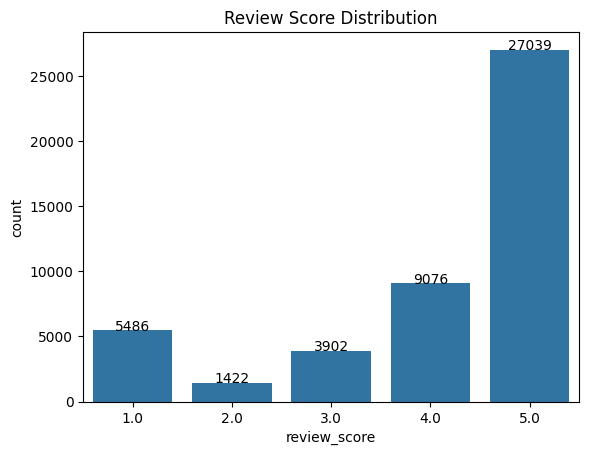

In [63]:
## 리뷰 점수 분포

# ax 변수에 반환값 저장
ax = sns.countplot(data=df23, x="review_score")
plt.title("Review Score Distribution")

# 막대 위 값 표시
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width()/2,  # x 중앙
        height + 0.1,                 # y 위쪽
        int(height),                  # 표시 값
        ha='center'                   # 중앙 정렬
    )

plt.show()

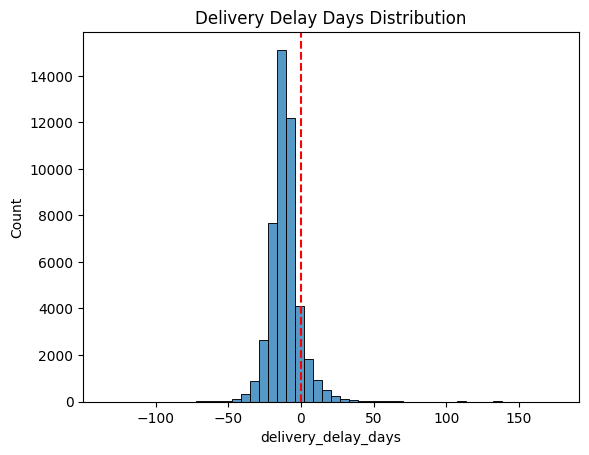

In [64]:
## 배송 지연 분포
sns.histplot(df23["delivery_delay_days"].dropna(), bins=50)
plt.axvline(0, color="red", linestyle="--")
plt.title("Delivery Delay Days Distribution")
plt.show()

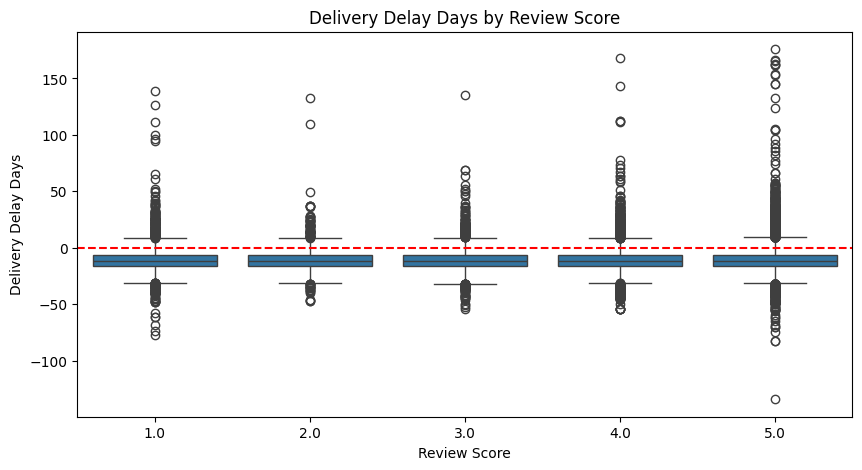

In [66]:
## 리뷰점수별 지연일 분포
# 저점(1~2점)에서 50일, 100일 이상 지연된 주문들 상대적으로 많다고 볼 수 있나?
# 고점(4~5점)에도 극단적 지연 주문 존재

plt.figure(figsize=(10, 5))
sns.boxplot(
    data=df23,
    x="review_score",
    y="delivery_delay_days"
)
plt.axhline(0, color="red", linestyle="--")
plt.title("Delivery Delay Days by Review Score")
plt.xlabel("Review Score")
plt.ylabel("Delivery Delay Days")
plt.show()


#### **3-2. 저점(1~2점) 리뷰 분석**

In [ ]:
## 저점 정의
# low_review == 1 : 저점(1~2점)
# low_review == 0 : 그 외

df32 = df23.copy()
df32["low_review"] = (df32["review_score"] <= 2).astype(int)

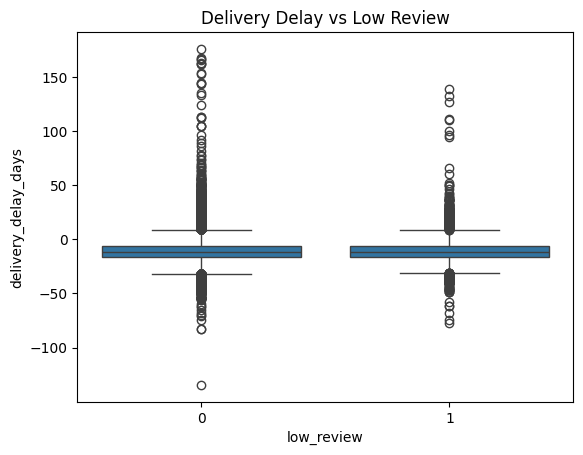

In [77]:
## 배송 지연 vs 리뷰
sns.boxplot(
    data=df32,
    x="low_review",
    y="delivery_delay_days"
)
plt.title("Delivery Delay vs Low Review")
plt.show()

In [86]:
## 저점 리뷰의 지연 비율
# 중고점 리뷰의 지연일 비율이 저점 리뷰보다 높은 이유는 N수 차이 일 수 있음

df32["is_late"] = (df32["delivery_delay_days"] > 0).astype(int)

result1 = df32.groupby("is_late")["low_review"].mean()[0]
result2 = df32.groupby("is_late")["low_review"].mean()[1]

print(f"저점 리뷰의 지연일 비율 : {result1*100:.1f}%")
print(f"중고점 리뷰의 지연일 비율 : {result2*100:.1f}%")

저점 리뷰의 지연일 비율 : 14.7%
중고점 리뷰의 지연일 비율 : 15.1%


#### **3-3. 배송 지연일 IQR 방식으로 이상치 제거**

In [70]:
## iqr 이상치 제거 방법 적용
df33 = df23.copy()
q3 = df33['delivery_delay_days'].quantile(0.75) 
q1 = df33['delivery_delay_days'].quantile(0.25)

iqr = q3 - q1

print(q3, q1, iqr)

-6.260543981481481 -16.42900462962963 10.16846064814815


In [71]:
def is_outlier(df):
    score = df['delivery_delay_days']
    if score > -17 + (1.5 * 10) or score < -7 - (1.5 * 10):
        return '이상치'
    else:
        return '이상치아님'

df33['이상치여부'] = df33.apply(is_outlier, axis = 1)

# 결과 확인
df33["이상치여부"].value_counts()

이상치여부
이상치아님    36020
이상치      10905
Name: count, dtype: int64

In [73]:
## iqr 방식 적용 이상치 제거 후 지연일 분포
df_no_outlier = df33[df33['이상치여부'] == '이상치아님'].copy()

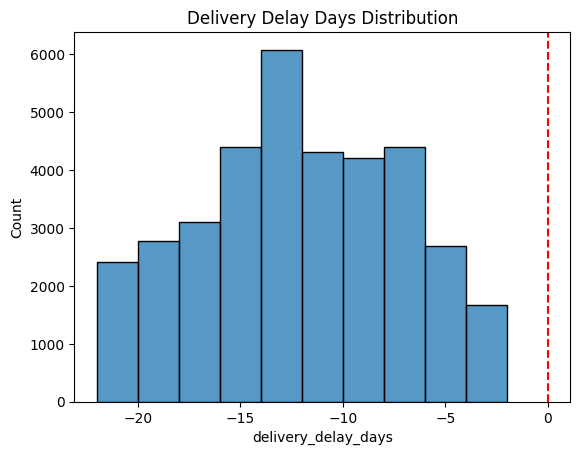

In [74]:
## 배송 지연 분포
# iqr 방식으로 배송지연일 이상치 제거 시 지연된 배송 데이터 확인 불가
# 적절한 방식 아님

sns.histplot(df_no_outlier["delivery_delay_days"].dropna(), bins=10)
plt.axvline(0, color="red", linestyle="--")
plt.title("Delivery Delay Days Distribution")
plt.show()

## **4. 추가 EDA (1) : 텍스트 기반 분석**

In [96]:
## 파생변수 생성
df4 = df23.copy()

# 출고지연 여부 변수 생성
df4['late_processing'] = (df4['order_delivered_carrier_date'] > df4['shipping_limit_date']).astype(int)

# 저점 정의
df4["low_review"] = (df4["review_score"] <= 2).astype(int)

# 텍스트 존재 여부
df4["has_review_text"] = df4["review_comment_message"].notna().astype(int)

# 리뷰 길이
df4["review_length"] = (df4["review_comment_message"].fillna("").str.len())

#### **4-1. 불만 키워드 기반 분석**

In [97]:
## 텍스트 표준화
# : 분석 편의를 위해 텍스트를 소문자, 공백 정리, 특수문자 제거 등으로 통일하는 과정

import unicodedata
import re

def normalize_text(text):
    # 결측치 처리
    if pd.isna(text):
        return ""
    # 소문자 변환
    text = text.lower()
    # 유니코드 정규화 (영어 발음 부호 등 표기를 통일)
    text = unicodedata.normalize("NFD", text)
    text = "".join(c for c in text if unicodedata.category(c) != "Mn")
    # 특수문자 제거
    text = re.sub(r"[^a-z\s]", " ", text)
    # 공백 정리 (연속된 공백->한 칸, 앞뒤 공백 제거)
    text = re.sub(r"\s+", " ", text).strip()
    return text


df4["review_text_norm"] = df4["review_comment_message"].apply(normalize_text)

In [99]:
## 불평 관련 키워드 카테고리별 정리

complaint_keywords = {
    "delivery": [
        "delay", "late",
        "demora", "atraso",                          # 지연에 관한 단어
        "nao chegou", "nao recebi", "nao entregue"   # 도착하지 않음, 받지 못함, 배송되지 않음
    ],
    "product": [
        "defect", "broken", "wrong", "damaged",       # 불량, 파손, 잘못된, 손상된
        "defeito", "quebrado", "danificado",          # 결함, 깨짐, 손상
        "produto errado", "veio errado"               # 잘못된 상품, 잘못 배송됨
    ],
    "seller": [
        "atendimento", "resposta", "nao responde",     # 고객 응대, 서비스, 답변, 답변하지 않음
        "mau atendimento", "pessimo atendimento"       # 나쁜 서비스, 최악의 서비스
    ],
    "refund": [
        "reembolso", "devolucao", "devolver",          # 환불, 반품, 반환하다
        "nao devolveu", "sem reembolso"                # 반환하지 않음, 환불 없음
    ]
}

for cat, kws in complaint_keywords.items():
    pattern = "|".join([re.escape(k) for k in kws])  
    df4[f"complaint_{cat}"] = df4["review_text_norm"].str.contains(pattern, na=False).astype(int)

In [101]:
seller_profile = (
    df4.groupby("seller_id")
    .agg(
        total_orders=("order_id", "count"),

        # 리뷰 기반
        avg_review_score=("review_score", "mean"),
        negative_review_ratio=("low_review", "mean"),

        # 텍스트 기반
        text_review_ratio=("has_review_text", "mean"),
        avg_review_length=("review_length", "mean"),
        long_review_ratio=("review_length", lambda x: (x > 100).mean()),

        # 배송/판매자 행동 기반
        avg_processing_days=("processing_days", "mean"),
        avg_shipping_days=("shipping_days", "mean"),
        shipment_delay_ratio=("late_processing", "mean"),
        avg_delivery_delay=("delivery_delay_days", "mean"),

        # 불만 주제 비율
        complaint_delivery=("complaint_delivery", "mean"),
        complaint_product=("complaint_product", "mean"),
        complaint_seller=("complaint_seller", "mean"),
        complaint_refund=("complaint_refund", "mean")
    )
    .reset_index()
)

#### **4-2. 리뷰 분석 시각화**

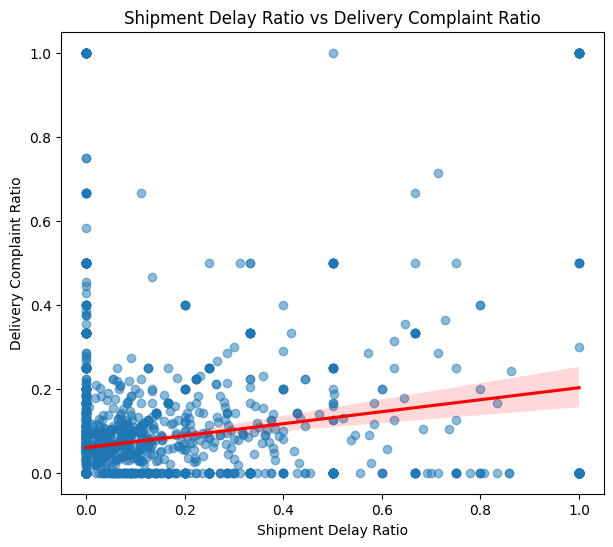

In [102]:
## 츨고 지연률 vs 배송 불만 텍스트
plt.figure(figsize=(7,6))
sns.regplot(
    data=seller_profile,
    x="shipment_delay_ratio",
    y="complaint_delivery",
    scatter_kws={"alpha":0.5},
    line_kws={"color":"red"}
)
plt.title("Shipment Delay Ratio vs Delivery Complaint Ratio")
plt.xlabel("Shipment Delay Ratio")
plt.ylabel("Delivery Complaint Ratio")
plt.show()

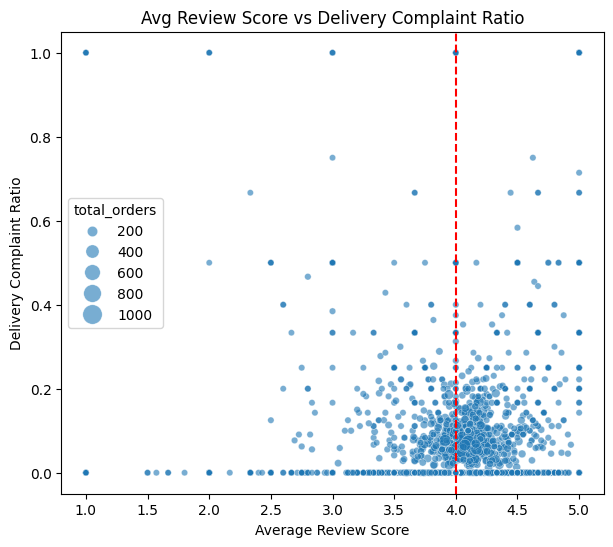

In [103]:
## 리뷰 점수 vs 텍스트 불만
# 평점은 괜찮은데 배송 불만은 많은 판매자가 존재함

plt.figure(figsize=(7,6))
sns.scatterplot(
    data=seller_profile,
    x="avg_review_score",
    y="complaint_delivery",
    size="total_orders",
    sizes=(20, 200),
    alpha=0.6
)
plt.axvline(4.0, color="red", linestyle="--")
plt.title("Avg Review Score vs Delivery Complaint Ratio")
plt.xlabel("Average Review Score")
plt.ylabel("Delivery Complaint Ratio")
plt.show()

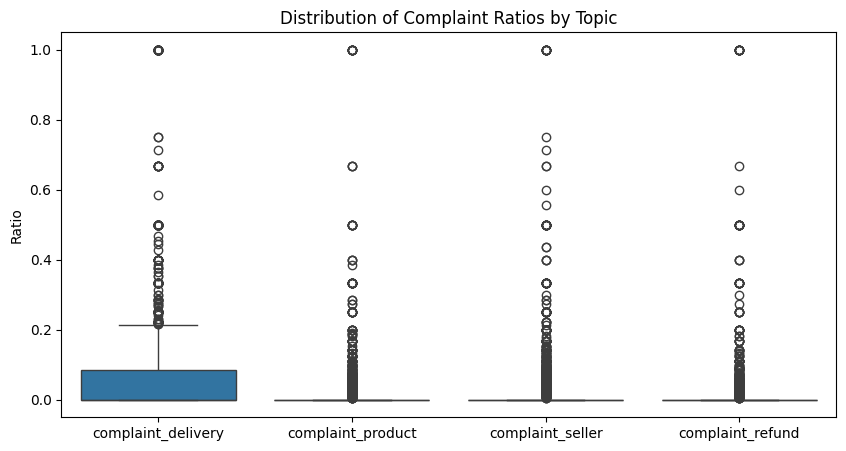

In [ ]:
## 텍스트 불만 주제별 비교
# 배송 불만인 경우 텍스트 리뷰 남길 가능성

plt.figure(figsize=(10,5))
sns.boxplot(
    data=seller_profile[
        ["complaint_delivery", "complaint_product",
         "complaint_seller", "complaint_refund"]
    ]
)
plt.title("Distribution of Complaint Ratios by Topic")
plt.ylabel("Ratio")
plt.show()

<Axes: >

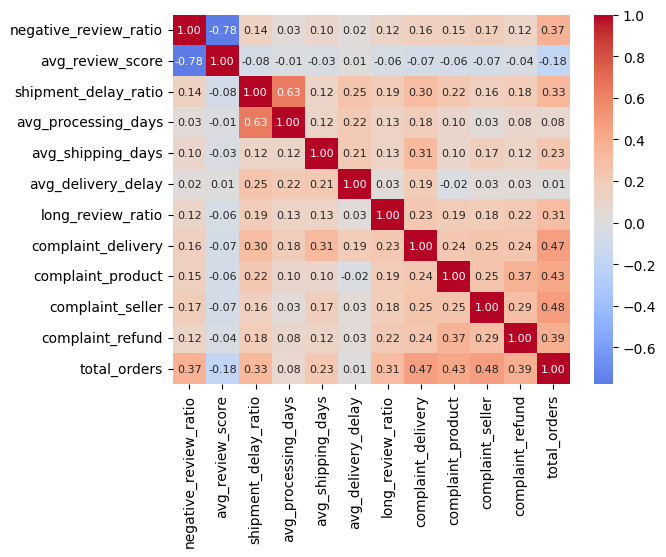

In [107]:
## 상관분석
corr_cols = [
    "negative_review_ratio",
    "avg_review_score",
    "shipment_delay_ratio",
    "avg_processing_days",
    "avg_shipping_days",
    "avg_delivery_delay",
    "long_review_ratio",
    "complaint_delivery",
    "complaint_product",
    "complaint_seller",
    "complaint_refund",
    "total_orders"
]

corr_df = seller_profile[corr_cols]

#
corr_matrix = corr_df.corr(method="spearman")

sns.heatmap(
    corr_matrix,
    cmap="coolwarm",
    center=0,
    annot=True,
    fmt=".2f",
    annot_kws={"size": 8}
)

[상관분석 결과 해석?]
- 총 주문수가 많은 판매자일수록 판매자에 대한 불평 리뷰가 많아짐 (r=0.48)

####
#### **4-3. 리뷰 점수는 좋지만 불만 텍스트 비율이 높은 판매자 탐색**

In [ ]:
## 점수는 괜찮은데 불만 텍스트가 많은 불일치 판매자 탐색
mismatch = seller_profile[
    (seller_profile["avg_review_score"] >= 4.0) &
    (seller_profile["complaint_delivery"] >= 0.20) &
    (seller_profile["total_orders"] >= 20)   # total_orders 이상치 기준 명확히 할 것!
].sort_values(["complaint_delivery", "total_orders"], ascending=False)

mismatch

,seller_id,total_orders,avg_review_score,negative_review_ratio,text_review_ratio,avg_review_length,long_review_ratio,avg_processing_days,avg_shipping_days,shipment_delay_ratio,avg_delivery_delay,complaint_delivery,complaint_product,complaint_seller,complaint_refund
1577,a420f60ff1aa9acc80d0e42959f2b313,33,4.181818,0.121212,1.0,63.484848,0.151515,1.320807,11.545182,0.000000,-9.556256,0.272727,0.000000,0.030303,0.000000
1281,835f0f7810c76831d6c7d24c7a646d4d,29,4.103448,0.103448,1.0,56.172414,0.068966,10.626455,9.595614,0.862069,-1.196532,0.241379,0.000000,0.034483,0.034483
39,04308b1ee57b6625f47df1d56f00eedf,39,4.051282,0.076923,1.0,80.769231,0.333333,5.971026,12.649014,0.358974,-11.275713,0.230769,0.000000,0.025641,0.025641
645,431af27f296bc6519d890aa5a05fdb11,49,4.244898,0.102041,1.0,75.102041,0.367347,3.928200,14.383816,0.183673,-6.222397,0.224490,0.040816,0.142857,0.061224
66,0691148aee60ca47977c187804f935ae,23,4.173913,0.130435,1.0,66.652174,0.304348,2.461141,13.245180,0.086957,-10.685075,0.217391,0.000000,0.000000,0.000000
853,582d4f8675b945722eda7c0cb61ba4c7,37,4.135135,0.135135,1.0,67.648649,0.135135,1.202978,8.115520,0.000000,-13.568316,0.216216,0.054054,0.027027,0.027027
1985,ce7d1888639e6fb06b2749cbfdac1ff7,29,4.379310,0.103448,1.0,67.758621,0.241379,2.035134,13.452642,0.068966,-11.454933,0.206897,0.000000,0.034483,0.000000
331,23613d49c3ac2bd302259e55c06c050c,39,4.358974,0.076923,1.0,62.897436,0.205128,4.110399,7.709924,0.333333,-12.406652,0.205128,0.051282,0.000000,0.025641
574,3c7c4a49ec3c6550809089c6a2ca9370,69,4.086957,0.173913,1.0,86.420290,0.347826,1.613158,8.944830,0.028986,-8.184204,0.202899,0.014493,0.014493,0.028986
1999,d05ae8f7a5bd1d2a690a44cd079e4e27,30,4.233333,0.133333,1.0,79.866667,0.300000,2.214650,9.626642,0.000000,-9.783398,0.200000,0.000000,0.033333,0.000000
